In [1]:
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import utils_xy
from torchvision import transforms, utils
import torch
import numpy as np
import nibabel as nib
import UNet3D
from random import randint
from PIL import Image
import torch.optim as optim
import time
import UNet
import torch.nn as nn

#### Set the visible GPU

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


We have 330 subjects, for every subject, there is 3 planes for T1w image, and 3 planes for Parc_5 image.
Pick a random subject

# I. Data Loading and preprocessing

In [3]:
for sub_idx in range(330):
    T1a_dir = '/home/xiaoyu/MRIdata/T1w/axial/sub{}'.format(sub_idx)
    T1s_dir = '/home/xiaoyu/MRIdata/T1w/sagittal/sub{}'.format(sub_idx)
    T1c_dir = '/home/xiaoyu/MRIdata/T1w/coronal/sub{}'.format(sub_idx)
    
    parc5a_dir = '/home/xiaoyu/MRIdata/parc_5/axial/sub{}'.format(sub_idx)
    parc5s_dir = '/home/xiaoyu/MRIdata/parc_5/sagittal/sub{}'.format(sub_idx)
    parc5c_dir = '/home/xiaoyu/MRIdata/parc_5/coronal/sub{}'.format(sub_idx)
    
    T1a_list = os.listdir(T1a_dir)
    T1s_list = os.listdir(T1s_dir)
    T1c_list = os.listdir(T1c_dir)
    
    parc5a_list = os.listdir(parc5a_dir)
    parc5s_list = os.listdir(parc5s_dir)
    parc5c_list = os.listdir(parc5c_dir)
    
    if sub_idx == 0: # set sub0 as test set.
        print('\nT1w Axial slices num:',len(T1a_list))
        print('T1w Sagittal slices num:',len(T1s_list))
        print('T1w Coronal slices num:',len(T1c_list))

        print('\nParc5 Axial slices num:',len(parc5a_list))
        print('Parc5 Sagittal slices num:',len(parc5s_list))
        print('Parc5 Coronal slices num:',len(parc5c_list))
        continue
    

    
    


T1w Axial slices num: 182
T1w Sagittal slices num: 217
T1w Coronal slices num: 182

Parc5 Axial slices num: 182
Parc5 Sagittal slices num: 217
Parc5 Coronal slices num: 182


In [4]:
# axial plane
for i in range(len(T1a_list)):
    T1a_dir = '/home/xiaoyu/MRIdata/T1w/axial/sub{}'.format(sub_idx)
    parc5a_dir = '/home/xiaoyu/MRIdata/parc_5/axial/sub{}'.format(sub_idx)
    T1a_str = T1a_list[i]
    parc5a_str = parc5a_list[i]
    T1a_arr = io.imread(os.path.join(T1a_dir, T1a_str))
    parc5a_arr = io.imread(os.path.join(parc5a_dir, parc5a_str))
    
    print('Image array data type: ', T1a_arr.dtype)
    print('Mask array data type: ', parc5a_arr.dtype)
    
    # make 2 tensors from the numpy array for image and mask respectively
    T1a_tensor = torch.from_numpy(T1a_arr)
    parc5a_tensor = torch.from_numpy(parc5a_arr)
    
    # observe the data size of the image and mask
    print('\nImage data size: ', T1a_tensor.size())
    print('Mask data size:', parc5a_tensor.size())
    
    if i ==0:
        break    

Image array data type:  uint8
Mask array data type:  uint8

Image data size:  torch.Size([182, 217])
Mask data size: torch.Size([182, 217])


#### Define a funciton for the visualization

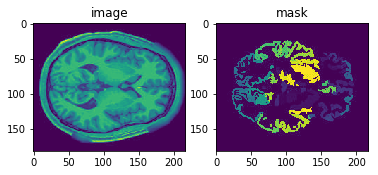

In [5]:
def show_mask(image, mask):
    """
    Show image and mask
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The training image segmentation
    """    
    plt.subplot(1,2,1)
    plt.title('image')
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('mask')
    plt.imshow(mask)
    plt.show()
    
# test the function
show_mask(T1a_arr, parc5a_arr)

### Find the unique color in mask

In [6]:
colors = torch.tensor([])
for i in range(len(T1a_list)):
    
    parc5a_dir = '/home/xiaoyu/MRIdata/parc_5/axial/sub{}'.format(sub_idx)
   
    parc5a_str = parc5a_list[i]
   
    parc5a_arr = io.imread(os.path.join(parc5a_dir, parc5a_str))
    
    parc5a_tensor = torch.from_numpy(parc5a_arr)
    
    unique_color = torch.unique(parc5a_tensor).type(torch.FloatTensor)
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
print(colors)
sorted_color, indices = torch.sort(colors)
print(sorted_color)
print(colors.dtype)
print(colors.size())

tensor([  0.,  10.,   6.,  12.,   5.,   2.,   3.,   7.,  15.,  19.,  25., 181.,
        199.,  22.,   8.,   1.,  13.,  16., 174., 182., 172., 167., 189., 162.,
        193., 176., 196., 178., 187., 201., 194., 175.,   4.,  26.,  14., 184.,
        190., 171., 185., 225., 186., 197., 177., 191.,   9.,  24., 203., 216.,
        213.,  11., 163., 188., 166., 200., 168., 214., 202., 183., 179., 219.,
        235., 221., 170., 159., 198., 180.,  27., 192., 195., 215., 204., 205.,
        228., 222., 157., 169., 208., 223., 206., 210., 207., 212., 211., 226.,
         20., 173., 220.,  18., 227., 231., 224., 165., 209., 217., 152.,  17.,
        164.,  32., 234., 230., 218., 232.,  21., 239.,  29.,  23., 229., 160.,
        233., 245., 241., 150.,  28., 237., 122., 114.,  34.,  30.,  42.,  40.,
        101., 121.,  89., 112., 129., 238., 243.,  50.,  38.,  36.,  31.,  37.,
         33.,  46.,  43.,  45., 116., 113., 118., 117., 236.,  49.,  35.,  41.,
        107.,  80., 111., 109., 120., 10

Found that there are 256 unique color in the mask, so there are 256 classes. There is no need to map since the class label is [0,255]

#### Define the Training set Class

In [7]:
class TrainDataset(Dataset):
    """Training dataset with mask image mapping to classes"""
    def __init__(self, T1a_dir, parc5a_dir, transform=None):
        """
        Args:
            T1a_dir (string): Directory with T1w image in axial plane
            transform (callable): Optional transform to be applied on a sample
            parc5a_dir (string): Directory with parcellation scale 5 in axial plane
        """
        self.T1a_dir = T1a_dir
        self.transform = transform
        self.parc5a_dir = parc5a_dir
        
    def __len__(self):
        T1a_list = os.listdir(self.T1a_dir)
        return len(T1a_list)
    
    
    def __getitem__(self, idx):
        T1a_list = os.listdir(T1a_dir)
        parc5a_list = os.listdir(parc5a_dir)
        
        T1a_str = T1a_list[idx]
        
        T1a_arr = io.imread(os.path.join(T1a_dir, T1a_str))
        T1a_tensor = torch.from_numpy(T1a_arr)
        
        compose_T1 = transforms.Compose([transforms.ToPILImage(), 
                                         transforms.Resize((128,128),interpolation=Image.NEAREST),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        T1a_tensor = torch.unsqueeze(T1a_tensor, dim = 0)
        T1a_tensor = compose_T1(T1a_tensor)
              
        parc5a_str = parc5a_list[idx]
    
        parc5a_arr = io.imread(os.path.join(parc5a_dir, parc5a_str))
        parc5a_tensor = torch.from_numpy(parc5a_arr)
        
        compose = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((128,128),interpolation=Image.NEAREST), 
                                      transforms.ToTensor()])
        
        parc5a_tensor = torch.unsqueeze(parc5a_tensor, dim = 0)
        parc5a_tensor = compose(parc5a_tensor)
        parc5a_tensor = parc5a_tensor.squeeze()
        
        parc5a_tensor = torch.round(parc5a_tensor / 0.0039).byte()
      
        sample = {'T1a':T1a_tensor, 'parc5a':parc5a_tensor}
        
        if self.transform:
            T1a = self.transform(T1a_tensor)
            sample = {'T1a':T1a, 'parc5a':parc5a}
            
        return sample

In [39]:
train_data = TrainDataset(T1a_dir=T1a_dir, parc5a_dir = parc5a_dir)
print('Total image number: {}'.format(len(train_data)))
colors = torch.tensor([])

for i in range(len(train_data)):
    sample = train_data[i]
    mask = sample['parc5a']
    unique_color = torch.unique(mask).float()
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
print(colors)
sorted_color, indices = torch.sort(colors)
print(sorted_color)

Total image number: 182
tensor([165.,   0.,   4.,   3.,   7.,   5.,  14.,  11.,   8.,   6.,   1.,  12.,
         19.,  22.,  13., 157., 186., 190.,  15.,   2.,  18.,   9., 178., 194.,
        204., 181., 187., 192., 206., 218., 213., 211., 215., 180., 183., 182.,
        195., 208., 175., 172., 197., 191., 196., 177., 221., 212., 209., 219.,
        217., 210., 222., 184., 168., 185., 171., 173., 170., 200., 179., 214.,
        224., 202., 226., 230.,  23., 189., 166., 193.,  17., 161., 159., 174.,
        216., 227., 201., 167., 188., 176., 198., 199., 223., 233., 207.,  33.,
         44.,  41.,  34.,  20., 142., 139., 144., 119.,  45.,  40.,  36.,  39.,
         38.,  29., 203., 150., 136., 137.,  55.,  28.,  37.,  43.,  32.,  42.,
         48.,  24., 128., 118.,  46.,  47.,  10.,  27.,  25.,  35.,  16., 158.,
        225., 126., 143., 140.,  62., 117., 114., 220.,  61.,  67.,  54.,  98.,
        131., 115., 133., 129., 169., 156., 205., 232., 151., 155.,  59., 112.,
        116., 10

### Test the traindataset class 
We can see here 
* T1wa data is in the range [-1,1], the data type is torch.float32 
* parc5a data value is (0,1,2,3...255), data type is torch.uint8  

In [9]:
train_data = TrainDataset(T1a_dir=T1a_dir, parc5a_dir = parc5a_dir)
print('Total T1a image number: {}'.format(len(train_data)))

maximum = torch.tensor([0],dtype=torch.float32)
minimum = torch.tensor([0],dtype=torch.float32)

for i in range(len(train_data)):
    sample = train_data[i]
    T1a = sample['T1a']
    parc5a = sample['parc5a']
        
    maxi = torch.max(T1a)
    mini = torch.min(T1a)

    if maximum < maxi:
        maximum = torch.max(T1a)
    if minimum > mini:
        minimum = torch.min(T1a)
 
print(maximum)
print(minimum)

Total T1a image number: 182
tensor(0.7882)
tensor(-1.)


T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.2863)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


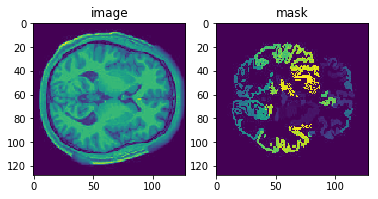

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.6784)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(20, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


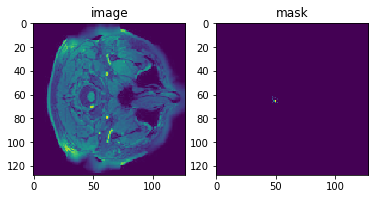

T1a info:
torch.Size([1, 128, 128])
torch.float32
tensor(0.5059)
tensor(-1.)

 parc5a info:
torch.uint8
torch.Size([128, 128])
tensor(237, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

Visualization:


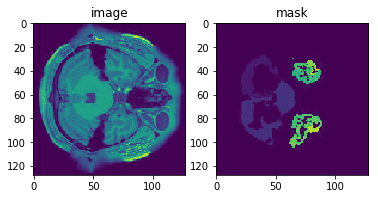

In [10]:
for i in range(len(train_data)):
    sample = train_data[i]
    T1a = sample['T1a']
    parc5a = sample['parc5a']
    
    print('T1a info:')
    print(T1a.size())
    print(T1a.dtype)
    print(torch.max(T1a))
    print(torch.min(T1a))
    
    print('\n parc5a info:')
    print(parc5a.dtype)
    print(parc5a.size())
    print(torch.max(parc5a))
    print(torch.min(parc5a))
    print(type(T1a))
    print('\nVisualization:')
    show_mask(T1a.squeeze(), parc5a)
    if i == 2:  
        break

### Use the dataloader in Pytorch to form the train dataset
Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

In [11]:
dataloader = DataLoader(train_data, batch_size = 5, shuffle = True, num_workers = 4)

In [12]:
print(len(dataloader))

37


In [13]:
for i_batch, sample_batched in enumerate(dataloader):
    print(sample_batched['T1a'].size())
    print(sample_batched['parc5a'].size())
    if i_batch ==0:
        break

torch.Size([5, 1, 128, 128])
torch.Size([5, 128, 128])


### Unet parameters

In [14]:
# input channel is 3, output channel is 1
unet = UNet.UNet(1,256,64)
print(unet)
unet_params = list(unet.parameters())
print("The length of the unet parameter is: ")
print(len(unet_params))
print("The conv1's weight: ")
print(unet_params[0].size()) # conv1's weight  0.4.
print("The weight's dtype: ")
print(unet_params[0].dtype)

nb_param=0
for param in unet.parameters():
    nb_param+=np.prod(list(param.data.size()))
print(nb_param)

UNet(
  (conv_in): double_conv(
    (doubleconv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): down(
    (downconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (doubleconv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [15]:
bs=5
x=torch.rand(bs,1,128,128)
y = unet(x)
print(y.size())

torch.Size([5, 256, 128, 128])


### Make sure the current device

In [16]:
current_device = torch.cuda.current_device()
torch.cuda.device(current_device)

In [17]:
torch.cuda.device_count()

1

In [18]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [19]:
unet = unet.to(device)

In [20]:
print(unet_params[0].dtype)

torch.float32


### Define the loss function and learning rate

In [21]:
criterion = nn.NLLLoss()

#### Inputs size: bs x 1 x 182 x 217 tensor, which is in range [-1,1], data type is float32
#### Labels size: bs x 182 x 217 tensor, the values is 0,1,2,... 255, data type is uint8

In [22]:
optimizer = optim.Adam(unet.parameters() ,lr=0.001)


start=time.time()
for epoch in range(1,500):
   
    
    # define the running loss
    running_loss = 0
    running_error = 0
    num_batches=0
      
    for i_batch, sample_batched in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        #get the inputs
        inputs, labels = sample_batched['T1a'], sample_batched['parc5a']
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs.requires_grad_()
        
        #forward + backward +optimize
        scores = unet(inputs)
      
        # Define the loss
        loss = criterion(scores, labels.long()) 
        loss.backward()
        optimizer.step()
        
        # compute and accumulate stats
        running_loss += loss.detach().item()
       
        num_batches+=1 
    
    # AVERAGE STATS THEN DISPLAY    
    total_loss = running_loss/num_batches
   
    elapsed = (time.time()-start)/60
        
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t loss=', total_loss )

       
print('Finish Training')

epoch= 1 	 time= 0.06389063199361165 min 	 loss= 4.82942499985566
epoch= 2 	 time= 0.14448610544204712 min 	 loss= 3.6980584827629297
epoch= 3 	 time= 0.22403952678044636 min 	 loss= 2.399743914604187
epoch= 4 	 time= 0.3046188513437907 min 	 loss= 1.3920477709254704
epoch= 5 	 time= 0.3853461464246114 min 	 loss= 0.984057441756532
epoch= 6 	 time= 0.46634008089701334 min 	 loss= 0.8813682987883285
epoch= 7 	 time= 0.5484629511833191 min 	 loss= 0.8929795071079925
epoch= 8 	 time= 0.6296875317891438 min 	 loss= 0.8672678671978615
epoch= 9 	 time= 0.712167763710022 min 	 loss= 0.8338843857919848
epoch= 10 	 time= 0.7939729213714599 min 	 loss= 0.8477827689132175
epoch= 11 	 time= 0.8757283647855123 min 	 loss= 0.8261973100739557
epoch= 12 	 time= 0.9584326426188151 min 	 loss= 0.8161068917126268
epoch= 13 	 time= 1.0413965741793314 min 	 loss= 0.8094369589879706
epoch= 14 	 time= 1.123583765824636 min 	 loss= 0.799555181248768
epoch= 15 	 time= 1.2063118100166321 min 	 loss= 0.798870580

epoch= 123 	 time= 10.29721432129542 min 	 loss= 0.5621370548709623
epoch= 124 	 time= 10.381333553791046 min 	 loss= 0.5437960624694824
epoch= 125 	 time= 10.465317320823669 min 	 loss= 0.5387341786251479
epoch= 126 	 time= 10.54911403656006 min 	 loss= 0.5395124600948514
epoch= 127 	 time= 10.631839366753896 min 	 loss= 0.5378179799866032
epoch= 128 	 time= 10.713656441370647 min 	 loss= 0.5352616378584424
epoch= 129 	 time= 10.796335351467132 min 	 loss= 0.5327699350293826
epoch= 130 	 time= 10.87912833293279 min 	 loss= 0.5316192360745894
epoch= 131 	 time= 10.962005714575449 min 	 loss= 0.5449076331145054
epoch= 132 	 time= 11.046140937010447 min 	 loss= 0.5298235480849808
epoch= 133 	 time= 11.129274574915568 min 	 loss= 0.5372253692633396
epoch= 134 	 time= 11.213226600488026 min 	 loss= 0.5248815534082619
epoch= 135 	 time= 11.296051001548767 min 	 loss= 0.522261253328415
epoch= 136 	 time= 11.379074315230051 min 	 loss= 0.5300008501555469
epoch= 137 	 time= 11.463214699427287 

epoch= 242 	 time= 20.25281745592753 min 	 loss= 0.42770868942544266
epoch= 243 	 time= 20.336937522888185 min 	 loss= 0.41929553851887985
epoch= 244 	 time= 20.418568046887717 min 	 loss= 0.4184270811242026
epoch= 245 	 time= 20.5010822335879 min 	 loss= 0.40229828814296303
epoch= 246 	 time= 20.584723484516143 min 	 loss= 0.4069616171355183
epoch= 247 	 time= 20.66781399647395 min 	 loss= 0.39886050308878357
epoch= 248 	 time= 20.750554084777832 min 	 loss= 0.40860866372649735
epoch= 249 	 time= 20.8335636417071 min 	 loss= 0.4062877254107514
epoch= 250 	 time= 20.916346073150635 min 	 loss= 0.39622687196006645
epoch= 251 	 time= 21.000222531954446 min 	 loss= 0.4011903141398688
epoch= 252 	 time= 21.08485244512558 min 	 loss= 0.392151088696099
epoch= 253 	 time= 21.169513881206512 min 	 loss= 0.3930979479809065
epoch= 254 	 time= 21.255340417226154 min 	 loss= 0.39281446647805135
epoch= 255 	 time= 21.341426281134286 min 	 loss= 0.3892077435110066
epoch= 256 	 time= 21.4288349469502

epoch= 361 	 time= 30.26426693201065 min 	 loss= 0.23837524038311597
epoch= 362 	 time= 30.345774694283804 min 	 loss= 0.24367261750975977
epoch= 363 	 time= 30.429684472084045 min 	 loss= 0.24078570165344187
epoch= 364 	 time= 30.512336254119873 min 	 loss= 0.22725368264710177
epoch= 365 	 time= 30.596255695819856 min 	 loss= 0.22455090299450062
epoch= 366 	 time= 30.679241359233856 min 	 loss= 0.2292282442386086
epoch= 367 	 time= 30.76321678161621 min 	 loss= 0.22673532326479215
epoch= 368 	 time= 30.848343809445698 min 	 loss= 0.2316889370212684
epoch= 369 	 time= 30.93116974035899 min 	 loss= 0.22808041448730068
epoch= 370 	 time= 31.01627708673477 min 	 loss= 0.23072021709427842
epoch= 371 	 time= 31.10012482404709 min 	 loss= 0.21859292171870334
epoch= 372 	 time= 31.184136760234832 min 	 loss= 0.21878360403147903
epoch= 373 	 time= 31.266673902670544 min 	 loss= 0.22065300757468148
epoch= 374 	 time= 31.350938606262208 min 	 loss= 0.22821342099357295
epoch= 375 	 time= 31.43360

epoch= 480 	 time= 40.22667983373006 min 	 loss= 0.15070807264261954
epoch= 481 	 time= 40.313417597611746 min 	 loss= 0.15422159851201483
epoch= 482 	 time= 40.39893668095271 min 	 loss= 0.1518012349418289
epoch= 483 	 time= 40.48581937154134 min 	 loss= 0.13792739156633615
epoch= 484 	 time= 40.5704311132431 min 	 loss= 0.13089660937721664
epoch= 485 	 time= 40.654247391223905 min 	 loss= 0.11958306067547686
epoch= 486 	 time= 40.73850912253062 min 	 loss= 0.1199192566847479
epoch= 487 	 time= 40.82341903448105 min 	 loss= 0.13018897054968653
epoch= 488 	 time= 40.90643853743871 min 	 loss= 0.1333883655433719
epoch= 489 	 time= 40.989137999216716 min 	 loss= 0.13848330624829475
epoch= 490 	 time= 41.071829839547476 min 	 loss= 0.13715132923696088
epoch= 491 	 time= 41.155551517009734 min 	 loss= 0.125673543095488
epoch= 492 	 time= 41.23809492588043 min 	 loss= 0.12694462995372108
epoch= 493 	 time= 41.32207578420639 min 	 loss= 0.12532342935132013
epoch= 494 	 time= 41.4061954696973

#### Choose image at random from the training set and see how good/bad are the predictions

In [26]:
T1a_dir = '/home/xiaoyu/MRIdata/T1w/axial/sub20'
parc5a_dir = '/home/xiaoyu/MRIdata/parc_5/axial/sub20'

test_data = TrainDataset(T1a_dir=T1a_dir, parc5a_dir = parc5a_dir)

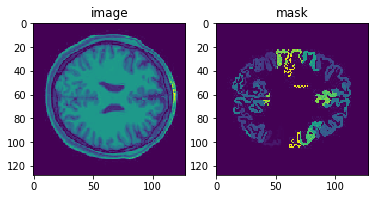

torch.Size([128, 128, 256])
tensor(1.)
tensor(0.)


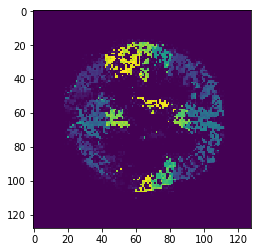

In [40]:
sample=train_data[6]
img = sample['T1a']
mask = sample['parc5a']

show_mask(img.squeeze(), mask)

img = img.unsqueeze(dim = 0)

img = img.to(device)


# feed it to network
scores =  unet(img)
scores = scores.detach().cpu().squeeze().permute(1,2,0)
print(scores.size())
scores = torch.exp(scores)
print(torch.max(scores))
print(torch.min(scores))
a,b = torch.max(scores,dim=2)
plt.imshow(b)
